Using TensorFlow backend.
C:\Users\Ayelet Rapaport\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ayelet Rapaport\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ayelet Rapaport\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ayelet Rapaport\anaconda3\lib\site-packag

values [[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
values2 [[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
values3 [[129.   -16.    -4.   ...   1.79   0.     0.  ]
 [148.   -15.    -4.   ...   2.68   0.     0.  ]
 [159.   -11.    -5.   ...   3.57   0.     0.  ]
 ...
 [ 10.   -22.    -3.   ... 242.7    0.     0.  ]
 [  8.   -22.    -4.   ... 246.72   0.     0.  ]
 [ 12.   -21.    -3.   ... 249.85   0.     0.  ]]
values4 [[0.12977867 0.35294122 0.24590163 ... 0.         0.         0.14889336]
 [0.14889336 0.36764708 0.24590163 ... 0.         0.         0.15995975]
 [0.15995975 0.4264706  0.22950819 ... 0.         0.         0.18209255]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.         0.       

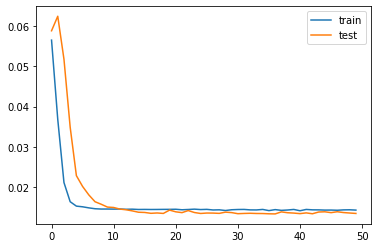

Test RMSE: 26.543


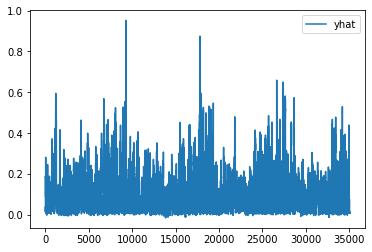

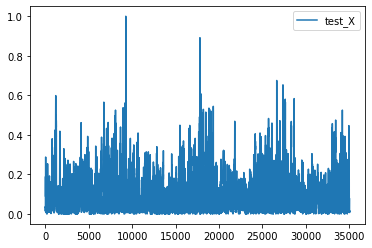

In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
#print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
#print('dataset1', dataset)
    
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values

	if dropnan:
		agg.dropna(inplace=True)
	agg.to_csv('agg.csv')  
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

print('values', values)

# integer encode direction
encoder = LabelEncoder()

values[:,4] = encoder.fit_transform(values[:,4])
print('values2', values)

# ensure all data is float
values = values.astype('float32')
print('values3', values)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())
 
# split into train and test sets
values = reframed.values
print('values4', values)
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
#print('train', train)
test = values[n_train_hours:, :]
#print('test', test)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
#print('train_X', train_X)
#print('train_y', train_y)

test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
#print(yhat)


test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#print(test_X)
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(yhat, label='yhat')
pyplot.legend()
pyplot.show()
pyplot.plot(test_y, label='test_X')
pyplot.legend()
pyplot.show()

